# Word embeddings

![embeddings relations](https://www.tensorflow.org/images/linear-relationships.png)
*From [Vector Representations of Words, Tensorflow tutorial](https://www.tensorflow.org/tutorials/representation/word2vec)*

The main idea of embeddings is to have fixed length representations for the tokens in a text regardless of the number of tokens in the vocabulary. So instead of each token representation having the shape [1XV] where V is vocab size, each token now has the shape [1 X D] where D is the embedding size (usually 50, 100, 200, 300). The numbers in the representation will no longer be 0s and 1s but rather floats that represent that token in a D-dimensional latent space. If the embeddings really did capture the relationship between tokens, then we should be able to inspect this latent space and confirm known relationships (we'll do this soon).

But how do we learn the embeddings the first place? The intuition behind embeddings is that the definition of a token depends on the token itself but on it's context. There are several different ways of doing this:

1. Given the word in the context, predict the target word (CBOW - continuous bag of words).
2. Given the target word, predict the context word (skip-gram).
3. Given a sequence of words, predict the next word (LM - language modeling).

All of these approaches involve create data to train our model on. Every word in a sentence becomes the target word and the context words are determines by a window. In the image below (skip-gram), the window size is 2. We repeat this for every sentence in our corpus and this results in our training data for the unsupervised task. This in an unsupervised learning technique since we don't have official labels for contexts. The idea is that similar target words will appear with similar contexts and we can learn this relationship by repeatedly training our mode with (context, target) pairs.

<img src="https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/images/skipgram.png" width=600>

We can learn embeddings using any of these approaches above and some work better than others. You can inspect the learned embeddings but the best way to choose an approach is to empirically validate the performance on a supervised task. We can learn embeddings by creating our models in PyTorch but instead, we're going to use a library that specializes in embeddings and topic modeling called [Gensim](https://radimrehurek.com/gensim/). 

## We train a simple model

t’s just not fun to just look at other people's models, so we’ll gradually come closer to solving a specific task: [Quora Question Pairs at kaggle](https://www.kaggle.com/c/quora-question-pairs):

In [58]:
import re
import spacy
import pandas as pd
import gensim
from gensim.models import Word2Vec

nlp = spacy.load('en', disable=['tagger', 'ner'])
# nlp.max_length = 1500000

In [59]:
sentences = []
with open('.data/harrypotter.txt', encoding='cp1252') as fp:
    for chunk in iter(lambda: fp.read(20480), b''):
        if len(chunk) == 0:
            break
        doc = nlp(chunk)
        sentences.extend(list(doc.sents))

In [60]:
# Preprocessing
def preprocess_text(text):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    text = text.strip()
    return text.split(" ")

In [61]:
# Clean sentences
corpus = [preprocess_text(sentence.text) for sentence in sentences]
print (corpus[11])

['but', 'i', 'hope', 'he', 'will', 'be', 'satisfied', '.']



Let's practice a small model on the received texts:

In [62]:
# Super fast because of optimized C code under the hood
model = Word2Vec(sentences=corpus, size=100, window=5, min_count=3, sg=1, negative=20)
print (model)

Word2Vec(vocab=4839, size=100, alpha=0.025)


In [63]:
# Vector for each word
model.wv.get_vector("potter")

array([ 0.09911099, -0.24065366, -0.12388526,  0.05252827, -0.02625669,
       -0.2993732 ,  0.19113553, -0.52691233,  0.04682967,  0.20761159,
       -0.16144556,  0.02848237,  0.05201204,  0.29872543,  0.44580722,
       -0.02316459,  0.45354912,  0.15123558,  0.05068282,  0.09364508,
       -0.20434359,  0.09209134, -0.22776553, -0.1760872 , -0.11605548,
        0.14396948, -0.0313121 ,  0.37195832,  0.23463877, -0.27198496,
       -0.12503941,  0.192079  , -0.20037068, -0.48973373,  0.41356143,
       -0.06233199, -0.44322222, -0.06030791,  0.2340393 ,  0.23766144,
        0.07633066,  0.40186253,  0.29663745,  0.29630676, -0.01898866,
       -0.18158609,  0.22070901,  0.00694801,  0.25233084, -0.07824248,
       -0.29054338, -0.31492782,  0.56950694,  0.474383  ,  0.4400003 ,
       -0.28735897,  0.04533708, -0.04102612,  0.1684576 , -0.2378773 ,
       -0.29382348, -0.01687524,  0.03385508,  0.27793425, -0.33548555,
        0.29570255, -0.3437492 , -0.03587561, -0.09659985,  0.18

In [65]:
# Get nearest neighbors (excluding itself)
model.wv.most_similar(positive="scar", topn=5)

[('pain', 0.9314314126968384),
 ('burning', 0.9144282937049866),
 ('forehead', 0.9121128916740417),
 ('mouth', 0.9066875576972961),
 ('cold', 0.9046509265899658)]

In [90]:
words = sorted(model.wv.vocab.keys(), key=lambda word: model.wv.vocab[word].count, reverse=True)[:100]

## Visualize the model

### PCA

The simplest linear dimension reduction method is __P__rincipial __C__omponent __A__nalysis.

The PCA searches for axes on which the data will have the largest scatter when projected.

![pca](https://i.stack.imgur.com/Q7HIP.gif)

As a result, you can take the projections onto the first few components - and save as much information as possible, reducing the dimension.

Beautiful visualizations can be found [here] (http://setosa.io/ev/principal-component-analysis/).

**Task** Use the PCA from sklearn, and then center and normalize the result.

In [101]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt

X = model.wv[model.wv.vocab]
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

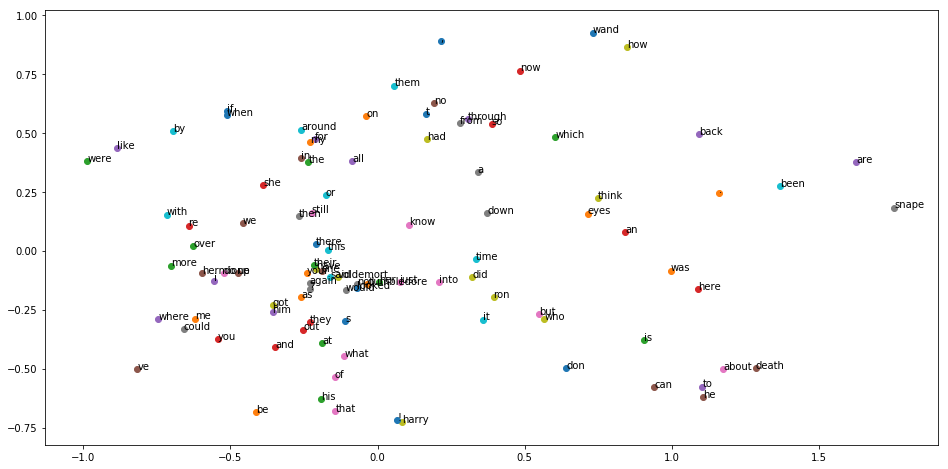

In [98]:
def plot_embeddings(words, embeddings, pca_results):
    fig= plt.figure(figsize=(16,8))
    for word in words:
        index = model.wv.vocab[word].index
        plt.scatter(pca_results[index, 0], pca_results[index, 1])
        plt.annotate(word, xy=(pca_results[index, 0], pca_results[index, 1]))
    plt.show()
    
plot_embeddings(words, embeddings=model, pca_results=pca_results)

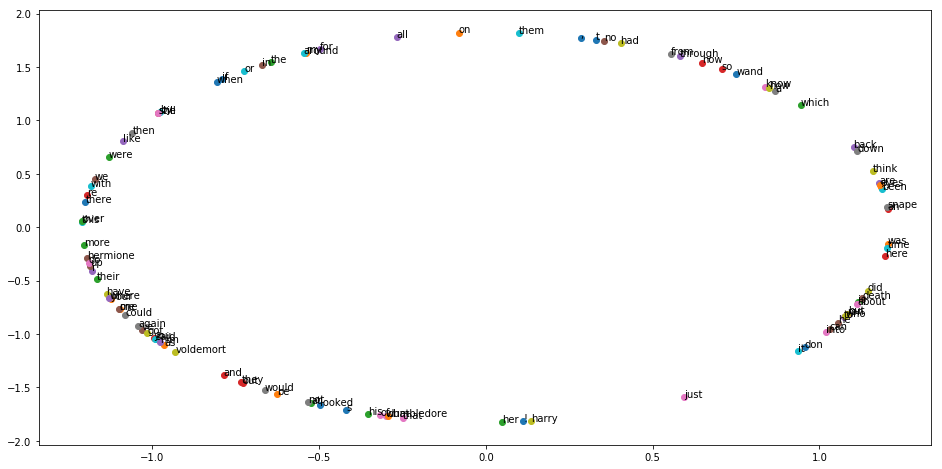

In [102]:
pca_results = preprocessing.normalize(pca_results)
pca_results = preprocessing.scale(pca_results, with_mean=0, with_std=1)

plot_embeddings(words, embeddings=model, pca_results=pca_results)

### TSNE

A more interesting and complex (non-linear) method for visualizing high-dimensional spaces is TSNE. You can look at it in detail [here] (https://distill.pub/2016/misread-tsne/) (even more beautiful pictures!).

**Task** As with PCA, use TSNE from sklearn and normalize + center the result.

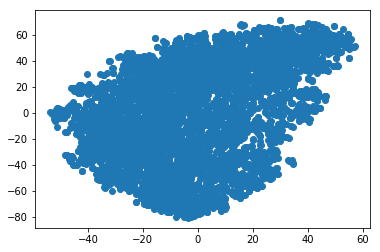

In [109]:
word_tsne = TSNE(n_components=2).fit_transform(X)
plt.scatter(word_tsne[:, 0], word_tsne[:, 1])

## Pretrained embeddings

There are several different ways to use embeddings. 
​
1. Use your own trained embeddings (trained on an unsupervised dataset).
2. Use pretrained embeddings (GloVe, word2vec, etc.)
3. Randomly initialized embeddings.
​
Once you have chosen embeddings, you can choose to freeze them or continue to train them using the supervised data (this could lead to overfitting). In this example, we're going to use GloVe embeddings and freeze them during training. Our task will be to predict an article's category given its title.

Let's load already trained model.(see which models and models are available at all, by calling `api.info ()`)

In [5]:
import gensim.downloader as api
api.info()

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1,
   'record_format': 'dict',
   'file_size': 6344358,
   'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py',
   'license': 'All files released for the task are free for general research use',
   'fields': {'2016-train': ['...'],
    '2016-dev': ['...'],
    '2017-test': ['...'],
    '2016-test': ['...']},
   'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.',
   'checksum': '701ea67acd82e75f95e1d8e62fb0ad29',
   'file_name': 'se

In [10]:
model = api.load("glove-twitter-25")  # load glove vectors
model.most_similar("cat")  # show words that similar to word '

[('dog', 0.9590819478034973),
 ('monkey', 0.9203578233718872),
 ('bear', 0.9143137335777283),
 ('pet', 0.9108031392097473),
 ('girl', 0.8880630135536194),
 ('horse', 0.8872727155685425),
 ('kitty', 0.8870542049407959),
 ('puppy', 0.886769711971283),
 ('hot', 0.8865255117416382),
 ('lady', 0.8845518827438354)]

In [66]:
count = 0
max_count = 15
for term in model.vocab:
    print(term)
#     print(model[term])
    count += 1
    if count >= max_count: break

<user>
.
:
rt
,
<repeat>
<hashtag>
<number>
<url>
!
i
a
"
the
?


## Using Embeddings 

In [42]:
import re
import os
import torch
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchtext
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchtext import vocab
from torchtext.data import Field, BucketIterator, TabularDataset, BPTTIterator
from download_files import download_from_url
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')
from sklearn.model_selection import train_test_split
from collections import Counter

In [13]:
file_name = '.data/news.csv'
df = pd.read_csv(file_name, header=0)
df.head()

,category,title
0,Business,Wall St. Bears Claw Back Into the Black (Reuters)
1,Business,Carlyle Looks Toward Commercial Aerospace (Reu...
2,Business,Oil and Economy Cloud Stocks' Outlook (Reuters)
3,Business,Iraq Halts Oil Exports from Main Southern Pipe...
4,Business,"Oil prices soar to all-time record, posing new..."


In [14]:
train, val = train_test_split(df, test_size=0.25)
train.to_csv(".data/train.csv", index=False)
val.to_csv(".data/val.csv", index=False)

In [15]:
TEXT = Field(init_token='<s>', eos_token='</s>', lower=True, tokenize='spacy')
LABEL = Field(pad_token=None, unk_token=None)

data_fields = [('category', LABEL), ('title', TEXT)]

train, val = TabularDataset.splits(path='.data/', train='train.csv', validation='val.csv', format='csv', skip_header=True, fields=data_fields)

In [16]:
TEXT.build_vocab(train, val)
LABEL.build_vocab(train, val)

In [17]:
def make_embeddings_matrix(words):
    embedding_dim = len(model[':'])
    vocab_size = len(model.vocab)
    embeddings = np.zeros((vocab_size, embedding_dim))
    for i, word in enumerate(words):
        if word in model.vocab:
            embeddings[i, :] = model[word]
        else:
            embedding_i = torch.zeros(1, embedding_dim)
            nn.init.xavier_uniform_(embedding_i)
            embeddings[i, :] = embedding_i
    return embeddings

embeddings = make_embeddings_matrix(TEXT.vocab.itos)

In [18]:
embeddings.shape

(1193514, 25)

In [19]:
traindl, valdl = BucketIterator.splits(datasets=(train, val), # specify train and validation Tabulardataset
                                            batch_sizes=(32,32),  # batch size of train and validation
                                            sort_key=lambda x: len(x.title), # on what attribute the text should be sorted
                                            sort_within_batch=True, 
                                            repeat=False)

In [20]:
class BatchGenerator:
    def __init__(self, dl, x_field, y_field):
        self.dl, self.x_field, self.y_field = dl, x_field, y_field
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl:
            X = getattr(batch, self.x_field)
            y = getattr(batch, self.y_field)
            yield (X,y)

In [21]:
train_batch_it = BatchGenerator(traindl, 'category', 'title')
print(next(iter(train_batch_it))[0])

tensor([[3, 1, 0, 1, 3, 0, 0, 3, 2, 0, 0, 2, 0, 2, 1, 3, 0, 1, 1, 3, 0, 2, 0, 2,
         0, 3, 1, 0, 1, 2, 1, 2]])


In [22]:
print(next(iter(train_batch_it))[1])

tensor([[    2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2],
        [  465,  2921,   100,  4606,  2101,   749,  4190,   536,  6746,  2008,
         22176,  2055,   565,   962,   339,    47,    36,   756,    59,   339,
            86,  1660,    24,  1592, 10291,  1146,   175,  5357,   117,  5589,
            80,  4386],
        [   36,     8,   719,     8, 20990,  2285,   879,     9,   777,  1521,
            12,    14,   179,   135,  1085,     4,  4395,  4453,    12,    10,
             8, 33053,   399,  1948,  3432,  2906,    85, 12422,     5,  2038,
          1366,  2243],
        [ 1520,  4325,  2295,  6624,    27,   551,  2806,   518,    12,  7298,
          2027,  4371,   616, 16838,   238,   325,  1234,    17,  1551,    18,
           169, 10450,     8,     4,   118,   378,     4,  

In [69]:
temp = next(iter(train_batch_it))[1]
temp.size()

torch.Size([7, 32])

In [73]:
# pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
# embeddings = nn.Embedding(embedding_dim=embedding_dim, num_embeddings=num_embeddings, padding_idx=0, _weight=pretrained_embeddings)

embedding_dim=25
num_embeddings=1193514
chennals = 100
hidden_dim = 100
classes = 4

embeddings = nn.Embedding(embedding_dim=embedding_dim, num_embeddings=num_embeddings)

In [79]:
output = embeddings(temp)
output.size()

torch.Size([7, 32, 25])

In [80]:
output = output.transpose(1, 2)
output.size()

torch.Size([7, 25, 32])

In [87]:
conv1 = nn.Conv1d(embedding_dim, chennals, kernel_size=2)
conv2 = nn.Conv1d(embedding_dim, chennals, kernel_size=3)
conv3 = nn.Conv1d(embedding_dim, chennals, kernel_size=4)

In [88]:
z1 = conv1(output)
z1 = F.max_pool1d(z1, z1.size(2)).squeeze(2)
z1.size()

torch.Size([7, 100])

In [89]:
z2 = conv3(output)
z2 = F.max_pool1d(z2, z2.size(2)).squeeze(2)
z2.size()

torch.Size([7, 100])

In [90]:
z3 = conv3(output)
z3 = F.max_pool1d(z3, z3.size(2)).squeeze(2)
z3.size()

torch.Size([7, 100])

In [92]:
z = torch.cat([z1, z2, z3], 1)
z.size()

torch.Size([7, 300])

In [93]:
dropout = nn.Dropout(0.3)
z = dropout(z)

In [96]:
fc = nn.Linear( chennals * 3, hidden_dim)
z = fc(z)
z.size()

torch.Size([7, 100])

## Phrase modeling

A simple and cheap way to calculate embedding of a phrase, when there are embeddingings of words - to average.

So let's do this: tokenize and lower-case the phrase, average the embeddingings of the words for which they are counted.

**Task** Write a function to count phrase embedding.

In [0]:
def get_phrase_embedding(model, phrase):    
    vector = np.zeros([model.vector_size], dtype='float32')
    
    <write me>
    
    return vector

In [0]:
vector = get_phrase_embedding(model, "I'm very sure. This never happened to me before...")

assert np.allclose(vector[::10],
                   np.array([ 0.30757686, -0.05861897,  0.143751  , -0.11104885, -0.96929336,
                             -0.21928601,  0.21652265,  0.14978765,  1.4842536 ,  0.017826  ],
                              dtype=np.float32))


Calculate the vector of all phrases.

In [0]:
text_vectors = np.array([get_phrase_embedding(model, phrase) for phrase in tokenized_texts])

And learn to look for coming!

**Assignment** Find the closest questions to it by line.

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

def find_nearest(model, text_vectors, texts, query, k=10):
    <write me, please>

In [0]:
results = find_nearest(model, text_vectors, texts, query="How do i enter the matrix?", k=10)

print('\n'.join(results))

assert len(results) == 10 and isinstance(results[0], str)
assert results[1] == 'How do I get to the dark web?'
assert results[4] == 'What can I do to save the world?'

In [0]:
find_nearest(model, text_vectors, texts, query="How does Trump?", k=10)

In [0]:
find_nearest(model, text_vectors, texts, query="Why don't i ask a question myself?", k=10)

## Begin the classification

### Bag-of-words

**Task** Let's collect tokens for the beginning.

In [0]:
tokenized_question1 = ...
tokenized_question2 = ...

**Task** Calculate cosine proximity between questions.

The easiest way is to implement the function of its calculation by hand:

$$\text{cosine_similarity}(x, y) = \frac{x^{T} y}{||x||\cdot ||y||}$$

In [0]:
<do smth>

cosine_similarities = <and calc the result>

We select the proximity threshold at which we will consider the texts to be the same.

**Task** Implement the `accuracy` function that calculates the accuracy of the classification at a given threshold.

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def accuracy(cosine_similarities, threshold):
    return <accuracy>

thresholds = np.linspace(0, 1, 100, endpoint=False)
plt.plot(thresholds, [accuracy(cosine_similarities, th) for th in thresholds])

And run the optimization:

In [0]:
from scipy.optimize import minimize_scalar

res = minimize_scalar(lambda x: -accuracy(cosine_similarities, x), bounds=(0.5, 0.99), method='bounded')
best_threshold = res.x
print('Threshold = {:.5f}, Accuracy = {:.2%}'.format(best_threshold, accuracy(cosine_similarities, best_threshold)))

### Tf-idf weights

Instead of stupidly averaging the vectors, you can average them based on the weights - the familiar tf-idf will help in this.

** Task ** Calculate weighted vector of questions. Use `TfidfVectorizer`

`TfidfVectorizer` returns the matrix` (samples_count, words_count) `. And our embeddings have the dimension `(words_count, embedding_dim)`. So you can just multiply them. Then each phrase - the sequence of words $ w_1, \ ldots, w_k $ - is transformed into the vector $ \ sum_i \ text {idf} (w_i) \ cdot \ text {embedding} (w_i) $. This vector should probably be normalized to the number of words $ k $.

** Task ** In addition to tf-idf, you can add filtering of stop words and punctuation.
Stop words can be taken from `nltk`:

```python
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
```

In [0]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from string import punctuation

<calculate tf-idf weighted vectors>

Посмотрим, что получается после фильтрации и векторизации:

In [0]:
for col in tfidf_question1[0].tocoo().col:
    print(model.index2word[col], end=' ')

print('\n' + ' '.join(tokenized_question1[0]))

**Task** Calculate quality with new vectors.

In [0]:
cosine_similarities = <calc it somehow>

res = minimize_scalar(lambda x: -accuracy(cosine_similarities, x), bounds=(0.8, 0.99), method='bounded')
best_threshold = res.x
print('Threshold = {:.5f}, Accuracy = {:.2%}'.format(best_threshold, accuracy(cosine_similarities, best_threshold)))

## Let's look inside learning word embeddings

The key idea is that a word can be defined by the context in which it occurs:
![contexts](https://image.ibb.co/mnQ2uz/2018_09_17_21_07_08.png)
*From [cs224n, Lecture 2](http://web.stanford.edu/class/cs224n/lectures/lecture2.pdf)*

Watch how everything learns, we will be here: [https://ronxin.github.io/wevi/](https://ronxin.github.io/wevi/).

## Got a word by word machine translation!

In [0]:
!wget -O ukr_rus.train.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vAK0SWXUqei4zTimMvIhH3ufGPsbnC_O"
!wget -O ukr_rus.test.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1W9R2F8OeKHXruo2sicZ6FgBJUTJc8Us_"
!wget -O fairy_tale.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1sq8zSroFeg_afw-60OmY8RATdu_T1tej"

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1d7OXuil646jUeDS1JNhP9XWlZogv6rbu'})
downloaded.GetContentFile('cc.ru.300.vec.zip')

downloaded = drive.CreateFile({'id': '1yAqwqgUHtMSfGS99WLGe5unSCyIXfIxi'})
downloaded.GetContentFile('cc.uk.300.vec.zip')

!unzip cc.ru.300.vec.zip
!unzip cc.uk.300.vec.zip


Let's write a simple implementation of the machine translation model.

The idea is based on the article [Word Translation Without Parallel Data] (https://arxiv.org/pdf/1710.04087.pdf). The authors in the repository have a lot more interesting: [https://github.com/facebookresearch/MUSE_ ((https://github.com/facebookresearch/MUSE)

And we will translate from Ukrainian to Russian.

! [] (https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/blue_cat_blue_whale.png)

*blue kit* vs. *blue kit*

In [0]:
from gensim.models import KeyedVectors

ru_emb = KeyedVectors.load_word2vec_format("cc.ru.300.vec")
uk_emb = KeyedVectors.load_word2vec_format("cc.uk.300.vec")


Look at a couple of serpeni-august (being a translation)

In [0]:
ru_emb.most_similar([ru_emb["август"]])

In [0]:
uk_emb.most_similar([uk_emb["серпень"]])

In [0]:
ru_emb.most_similar([uk_emb["серпень"]])

In [0]:
def load_word_pairs(filename):
    uk_ru_pairs = []
    uk_vectors = []
    ru_vectors = []
    with open(filename, "r", encoding='utf8') as inpf:
        for line in inpf:
            uk, ru = line.rstrip().split("\t")
            if uk not in uk_emb or ru not in ru_emb:
                continue
            uk_ru_pairs.append((uk, ru))
            uk_vectors.append(uk_emb[uk])
            ru_vectors.append(ru_emb[ru])
    return uk_ru_pairs, np.array(uk_vectors), np.array(ru_vectors)


uk_ru_train, X_train, Y_train = load_word_pairs("ukr_rus.train.txt")
uk_ru_test, X_test, Y_test = load_word_pairs("ukr_rus.test.txt")

### We learn mapping from one space to another

We have pairs of words that match each other, and their embedding. Let's find a transformation from one space to another, in order to bring the words we know to us:

$$W^*= \arg\min_W ||WX - Y||_F, \text{где} ||*||_F - \text{норма Фробениуса}$$

This function is very similar to linear regression (without bias).

**Task** Implement it - use `LinearRegression` from sklearn with` fit_intercept = False`:

In [0]:
mapping = ...

Check where the serpen will go:

In [0]:
august = mapping.predict(uk_emb["серпень"].reshape(1, -1))
ru_emb.most_similar(august)

It should turn out that the top contains different months, but August is not the first.

We will measure percision top-k with k = 1, 5, 10.

**Task** Implement the following function:

In [0]:
def precision(pairs, mapped_vectors, topn=1):
    """
    :args:
        pairs = list of right word pairs [(uk_word_0, ru_word_0), ...]
        mapped_vectors = list of embeddings after mapping from source embedding space to destination embedding space
        topn = the number of nearest neighbours in destination embedding space to choose from
    :returns:
        precision_val, float number, total number of words for those we can find right translation at top K.
    """
    assert len(pairs) == len(ru_vectors)
    num_matches = 0
    for i, (_, ru) in enumerate(pairs):
        <write code here>
    precision_val = num_matches / len(pairs)
    return precision_val

In [0]:
assert precision([("серпень", "август")], august, topn=5) == 0.0
assert precision([("серпень", "август")], august, topn=9) == 1.0
assert precision([("серпень", "август")], august, topn=10) == 1.0

In [0]:
assert precision(uk_ru_test, X_test) == 0.0
assert precision(uk_ru_test, Y_test) == 1.0

In [0]:
precision_top1 = precision(uk_ru_test, mapping.predict(X_test), 1)
precision_top5 = precision(uk_ru_test, mapping.predict(X_test), 5)

assert precision_top1 >= 0.635
assert precision_top5 >= 0.813

### Improving mapping

It can be shown that mapping is better to build orthogonal:
$$W^*= \arg\min_W ||WX - Y||_F \text{, где: } W^TW = I$$

SVD:
$$X^TY=U\Sigma V^T\text{, singular value decompostion}$$

$$W^*=UV^T$$

**Task** Implement this feature.

In [0]:
def learn_transform(X_train, Y_train):
    """ 
    :returns: W* : float matrix[emb_dim x emb_dim] as defined in formulae above
    """
    <write code there>

In [0]:
W = learn_transform(X_train, Y_train)

In [0]:
ru_emb.most_similar([np.matmul(uk_emb["серпень"], W)])

In [0]:
assert precision(uk_ru_test, np.matmul(X_test, W)) >= 0.653
assert precision(uk_ru_test, np.matmul(X_test, W), 5) >= 0.824

### We are writing a translator


We implement a simple word-for-word translator - for each word we will look for its nearest neighbor in the common embedding space. If the word is not in the inserts - just copy it.

In [0]:
with open("fairy_tale.txt", "r") as in f:
    uk_sentences = [line.rstrip().lower() for line in in f]

In [0]:
def translate(sentence):
    """
    :args:
        sentence - sentence in Ukrainian (str)
    :returns:
        translation - sentence in Russian (str)

    * find ukrainian embedding for each word in sentence
    * transform ukrainian embedding vector
    * find nearest russian word and replace
    """
    <implement it!>

In [0]:
assert translate(".") == "."
assert translate("1 , 3") == "1 , 3"
assert translate("кіт зловив мишу") == "кот поймал мышку"

In [0]:
for sentence in uk_sentences:
    print("src: {}\ndst: {}\n".format(sentence, translate(sentence)))

## Referrence

[On word embeddings - Part 1, Sebastian Ruder](http://ruder.io/word-embeddings-1/)  
[Deep Learning, NLP, and Representations, Christopher Olah](http://colah.github.io/posts/2014-07-NLP-RNNs-Representations/)  
[Making Sense of Word Embeddings (2016), Pelevina et al](http://anthology.aclweb.org/W16-1620)    
[Evaluation methods for unsupervised word embeddings (2015), T. Schnabel](http://www.aclweb.org/anthology/D15-1036)  
[Intrinsic Evaluation of Word Vectors Fails to Predict Extrinsic Performance (2016), B. Chiu](https://www.aclweb.org/anthology/W/W16/W16-2501.pdf)  
[Problems With Evaluation of Word Embeddings Using Word Similarity Tasks (2016), M. Faruqui](https://arxiv.org/pdf/1605.02276.pdf)  
[Improving Reliability of Word Similarity Evaluation by Redesigning Annotation Task and Performance Measure (2016), Oded Avraham, Yoav Goldberg](https://arxiv.org/pdf/1611.03641.pdf)  
[Evaluating Word Embeddings Using a Representative Suite of Practical Tasks (2016), N. Nayak](https://cs.stanford.edu/~angeli/papers/2016-acl-veceval.pdf)  
[Word Vector Representations: word2vec, Lecture 2, cs224n](https://www.youtube.com/watch?v=ERibwqs9p38)